In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

# qcdenoise imports
from qcdenoise import DenseModel, AdjTModel, AdjTAsymModel 
from qcdenoise.io_utils import QCIRCDataSet
from qcdenoise.ml_utils import train, test

### Load Data

In [7]:
data_path = '/data/MLQC/GraphState_nqbits9_DeviceNoise_040620'
traindata = QCIRCDataSet('%s_train.lmdb' % data_path, debug=False)
testdata = QCIRCDataSet('%s_test.lmdb' % data_path, debug=False)
print('Total # of samples in train set: {}, test set:{}'.format(len(traindata), len(testdata)))
trainloader = DataLoader(traindata, batch_size=64, shuffle=True, pin_memory=True, drop_last=True)
testloader = DataLoader(testdata, batch_size=64, shuffle=True, pin_memory=True, drop_last=True)
if not os.path.exists(data_path):
    os.mkdir(data_path)

Total # of samples in train set: 7600, test set:380


#### Plot a sample

Text(0.5, 1.0, 'Adjacency Tensor, plane=0')

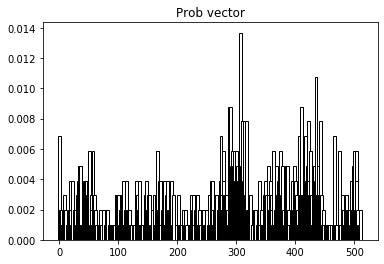

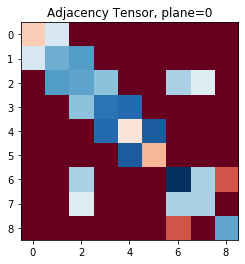

In [8]:
idx = np.random.randint(0, len(traindata)-1)
inputs, targets, encodings =  traindata[idx]['input'], traindata[idx]['target'], traindata[idx]['encoding']
inputs_dim = inputs.shape[0]
targets_dim = targets.shape[0]
encodings_dim = encodings.shape
plt.figure(1)
plt.bar(np.arange(inputs_dim), inputs.numpy(), width=5, color='w', edgecolor='k')
plt.title("Prob vector")
plt.figure(2)
plt.imshow(encodings.numpy()[0], cmap='RdBu')
plt.title("Adjacency Tensor, plane=0")

### Model

In [9]:
p_dropout=0.1
inputs_dim = inputs.shape[0]
targets_dim = targets.shape[0]
encodings_dim = encodings.shape
net_res = AdjTAsymModel(inputs_dim=inputs_dim, targets_dim=targets_dim, encodings_dim=encodings_dim, 
                                  combine_mode='Multiply', asym_mode='residual', p_dropout=p_dropout)
# print('AdjNet (Residual Units):\n', net_res)
net_dense = AdjTAsymModel(inputs_dim=inputs_dim, targets_dim=targets_dim, encodings_dim=encodings_dim, 
                                  combine_mode='Multiply', asym_mode='dense', p_dropout=p_dropout)
# print('AdjNet (Dense Units):\n',net_dense)

### Train

#### loss functions

In [10]:
def mse(outputs, targets):
    MSE = torch.nn.MSELoss(reduction='sum')
    outputs = F.softmax(outputs, dim=1)
    return MSE(outputs, targets)

def kl(outputs, targets):
    KL = torch.nn.KLDivLoss(reduction='sum')
    outputs = F.log_softmax(outputs, dim=1)
    return KL(outputs, targets)

#### Optimizer/Learning policy

In [11]:
def exp_scheduler(net, ilr=1e-3, lr_decay=0.9, weight_decay=1e-5):
    optimizer = optim.Adam(net.parameters(), lr=ilr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)
    return scheduler, optimizer


#### Dense Block 

In [12]:
model_path = os.path.join(data_path,'dense_model_0p1.pt')
loss_func = kl
scheduler, optimizer = exp_scheduler(net_dense, ilr=1e-3, lr_decay=0.95, weight_decay=2e-4)
test_func_args = (net_dense, testloader, loss_func)
dense_logs = train(net_dense, trainloader, loss_func, scheduler, optimizer, save_epoch=1,
      step_log= 500, num_epochs=10, test_epoch=1, test_func_args=test_func_args, path=model_path)

Test Data:
Batches=5, Average Loss= 78.374
Test Data:
Batches=5, Average Loss= 74.546
Test Data:
Batches=5, Average Loss= 74.535
Test Data:
Batches=5, Average Loss= 74.319
Test Data:
Batches=5, Average Loss= 74.035
Epoch=5, Lr= 0.000774, Step=  500, Loss=72.895
Test Data:
Batches=5, Average Loss= 74.358
Test Data:
Batches=5, Average Loss= 73.409


KeyboardInterrupt: 

In [ ]:
logs = dense_logs
fig, ax = plt.subplots()
ax.plot(logs["step"], logs["loss"], label="Train", marker='o', linestyle='dashed')
ax.plot(logs["test_step"], logs["test_loss"], label="Test", marker='^', linestyle='dashed')
ax.set_xlabel("Iterations", fontsize=14)
ax.set_ylabel("Loss (KL Divergence)", fontsize=14)
ax.legend()
fig.savefig("training_drp0p25_no2d_wd1em4_dense.png", dpi=300)

In [37]:
logs["test_loss"][-10:]

[20.68298620402361,
 20.424625894856632,
 19.491018786988743,
 19.73658208597982,
 19.017424796746372,
 18.59131188219901,
 18.728970001400672,
 18.228699598175794,
 17.838651154959212,
 18.052287233508526]

#### Residual Block 

In [28]:
model_path = os.path.join(data_path,'residual_model_0p1.pt')
loss_func = kl
scheduler, optimizer = exp_scheduler(net_res, ilr=1e-3, lr_decay=0.9, weight_decay=5e-4)
test_func_args = (net_res, testloader, loss_func)
res_logs = train(net_res, trainloader, loss_func, scheduler, optimizer, save_epoch=1, lr=1e-3, 
      step_log= 250, num_epochs=5, test_epoch=1, test_func_args=test_func_args, path=model_path)

Test Data:
Batches=1187, Average Loss= 77.716
Epoch=1, Lr= 0.000900, Step=  250, Loss=71.933
Epoch=1, Lr= 0.000900, Step=  500, Loss=68.886
Epoch=1, Lr= 0.000900, Step=  750, Loss=66.906
Epoch=1, Lr= 0.000900, Step= 1000, Loss=65.063
Epoch=1, Lr= 0.000900, Step= 1250, Loss=63.726
Epoch=1, Lr= 0.000900, Step= 1500, Loss=61.854
Epoch=1, Lr= 0.000900, Step= 1750, Loss=61.208
Epoch=1, Lr= 0.000900, Step= 2000, Loss=60.190
Epoch=1, Lr= 0.000900, Step= 2250, Loss=59.037
Epoch=1, Lr= 0.000900, Step= 2500, Loss=57.490
Epoch=1, Lr= 0.000900, Step= 2750, Loss=56.426
Epoch=1, Lr= 0.000900, Step= 3000, Loss=54.747
Epoch=1, Lr= 0.000900, Step= 3250, Loss=54.283
Epoch=1, Lr= 0.000900, Step= 3500, Loss=53.204
Epoch=1, Lr= 0.000900, Step= 3750, Loss=52.335
Epoch=1, Lr= 0.000900, Step= 4000, Loss=51.991
Epoch=1, Lr= 0.000900, Step= 4250, Loss=51.012
Epoch=1, Lr= 0.000900, Step= 4500, Loss=49.895
Epoch=1, Lr= 0.000900, Step= 4750, Loss=49.719
Epoch=1, Lr= 0.000900, Step= 5000, Loss=49.318
Epoch=1, Lr= 0

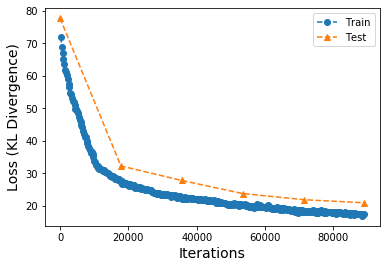

In [29]:
logs = res_logs
fig, ax = plt.subplots()
ax.plot(logs["step"], logs["loss"], label="Train", marker='o', linestyle='dashed')
ax.plot(logs["test_step"], logs["test_loss"], label="Test", marker='^', linestyle='dashed')
ax.set_xlabel("Iterations", fontsize=14)
ax.set_ylabel("Loss (KL Divergence)", fontsize=14)
ax.legend()
fig.savefig("training_drp0p25_wd1em4_residual.png", dpi=300)

#### Load Trained Model from checkpoint

In [50]:
model_path = 'data/GraphState_nqbits9_UnitaryNoise_032920/residual_model_0.0002_0.1.pt'
net_res = AdjTAsymModel(inputs_dim=inputs_dim, targets_dim=targets_dim, encodings_dim=encodings_dim, 
                        combine_mode='Multiply', asym_mode='residual')
net_res.load_state_dict(torch.load(model_path))

model_path = 'data/GraphState_nqbits9_UnitaryNoise_032920/dense_model_0p1.pt'
net_dense = AdjTAsymModel(inputs_dim=inputs_dim, targets_dim=targets_dim, encodings_dim=encodings_dim, 
                        combine_mode='Multiply', asym_mode='dense')
net_dense.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [62]:
13.994/64

0.21865625

### Test

In [51]:
test(net_res, testloader, kl)
test(net_dense, testloader, kl)

Batches=1187, Average Loss= 13.994
Batches=1187, Average Loss= 15.395


sample=16585


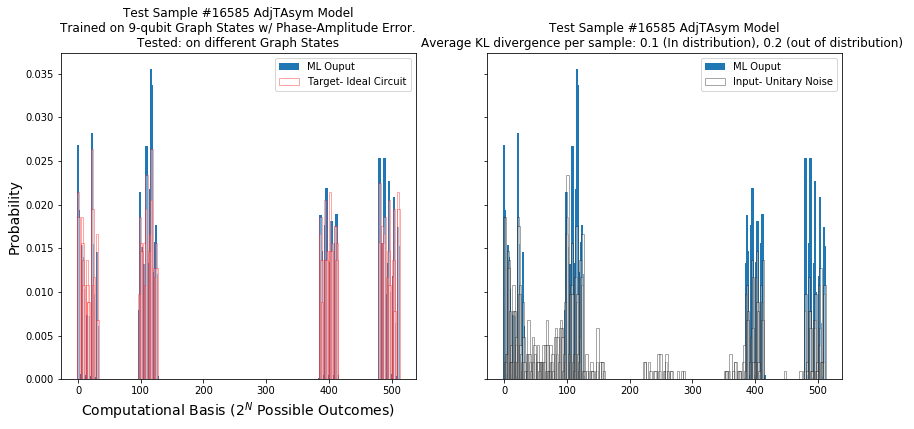

In [67]:
idx = np.random.randint(0, len(testdata)-1)
print('sample=%d'%idx)
inputs, targets, encodings = testdata[idx]['input'], testdata[idx]['target'], testdata[idx]['encoding']
with torch.no_grad():
    inputs = torch.unsqueeze(inputs,0)
    encodings = torch.unsqueeze(encodings, 0)
    net = net_res.to('cpu')
    net.eval()
    outputs_res = net(inputs, encodings)
    outputs_res = F.softmax(outputs_res)
fig,axes = plt.subplots(1,2,figsize=(14,6), sharex=True, sharey=True)
axes[0].bar(np.arange(inputs_dim), np.squeeze(outputs_res.numpy()), width=4, label='ML Ouput')
axes[0].bar(np.arange(inputs_dim), np.squeeze(targets.numpy()), width=4, label='Target- Ideal Circuit', color='w', edgecolor='r', alpha=0.35)
axes[1].bar(np.arange(inputs_dim), np.squeeze(outputs_res.numpy()), width=4, label='ML Ouput')
axes[1].bar(np.arange(inputs_dim), np.squeeze(inputs.numpy()), width=4, label='Input- Unitary Noise', color='w', edgecolor='k', alpha=0.35)
axes[0].set_title('Test Sample #%d AdjTAsym Model\nTrained on 9-qubit Graph States w/ Phase-Amplitude Error.\n'\
             'Tested: on different Graph States'%idx, fontsize=12)
axes[1].set_title('Test Sample #%d AdjTAsym Model\nAverage KL divergence per sample: 0.1 (In distribution), 0.2 (out of distribution) ' %idx, fontsize=12)
axes[0].set_xlabel("Computational Basis ($2^N$ Possible Outcomes)", fontsize=14)
axes[0].set_ylabel("Probability", fontsize=14)
axes[0].legend()
axes[1].legend()

In [68]:
fig.savefig("graphstate_nqubits9_032920_unitarynoise_residual.png", dpi=300)

sample=25382


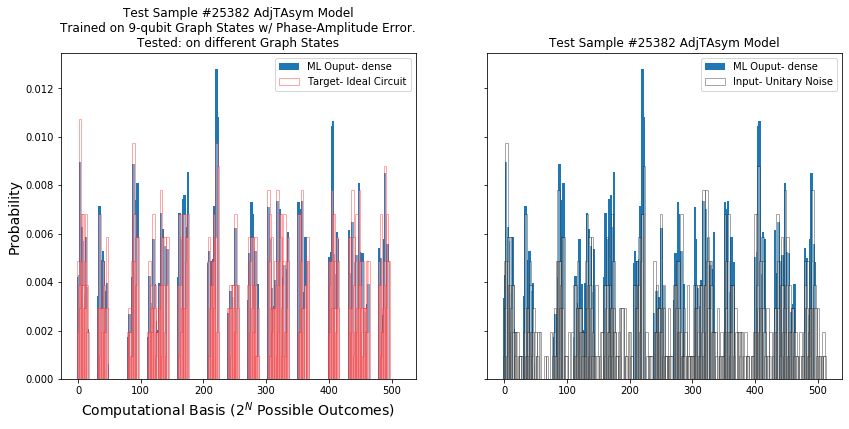

In [60]:
idx = np.random.randint(0, len(testdata)-1)
print('sample=%d'%idx)
inputs, targets, encodings = testdata[idx]['input'], testdata[idx]['target'], testdata[idx]['encoding']
with torch.no_grad():
    inputs = torch.unsqueeze(inputs,0)
    encodings = torch.unsqueeze(encodings, 0)
    net = net_dense.to('cpu')
    net.eval()
    outputs_dense = net(inputs, encodings)
    outputs_dense = F.softmax(outputs_dense)
fig,axes = plt.subplots(1,2,figsize=(14,6), sharex=True, sharey=True)
axes[0].bar(np.arange(inputs_dim), np.squeeze(outputs_dense.numpy()), width=4, label='ML Ouput- dense')
axes[0].bar(np.arange(inputs_dim), np.squeeze(targets.numpy()), width=4, label='Target- Ideal Circuit', color='w', edgecolor='r', alpha=0.35)
axes[1].bar(np.arange(inputs_dim), np.squeeze(outputs_dense.numpy()), width=4, label='ML Ouput- dense')
axes[1].bar(np.arange(inputs_dim), np.squeeze(inputs.numpy()), width=4, label='Input- Unitary Noise', color='w', edgecolor='k', alpha=0.35)
axes[0].set_title('Test Sample #%d AdjTAsym Model\nTrained on 9-qubit Graph States w/ Phase-Amplitude Error.\n'\
             'Tested: on different Graph States'%idx, fontsize=12)
axes[1].set_title('Test Sample #%d AdjTAsym Model' %idx, fontsize=12)
axes[0].set_xlabel("Computational Basis ($2^N$ Possible Outcomes)", fontsize=14)
axes[0].set_ylabel("Probability", fontsize=14)
axes[0].legend()
axes[1].legend()